# Thomas Fire and AQI Inspection
## Author: Maxwell Patterson
#### GitHub Link: https://github.com/maxwellpatt/eds220-pres-repo

## About

#### Purpose
This notebook is designed to perform a comprehensive environmental analysis using two distinct approaches: Air Quality Index (AQI) trend analysis for Santa Barbara County from 2017-2018 and remote sensing data visualization of the 2017 Thomas Fire in California. The primary objectives include demonstrating data manipulation and visualization techniques, time-series analysis for AQI, and the application of true and false color imagery in assessing wildfire impacts.

#### Highlights of Analysis
- AQI Trend Analysis (2017-2018): Retrieval and preparation of AQI data from the EPA, focusing on data cleaning, concatenation, and column modification. Implementation of a 5-day rolling average for AQI to smooth daily variations and a detailed visualization of these trends over time.
- Remote Sensing Data Visualization: Utilization of Landsat 8 satellite imagery for creating true and false color images of Santa Barbara. Integration of California fire perimeter data to assess the spatial impact of the Thomas Fire, enhancing the understanding of wildfire effects through geospatial analysis.
- Data Concatenation and Cleaning: Merging AQI datasets for two consecutive years, followed by data cleaning processes such as modifying column names for consistency and dropping unnecessary columns.
- Visualization Techniques: Development of plots and maps to compare daily AQI values with the 5-day average and to overlay wildfire perimeters on satellite imagery, providing a clear visual representation of both air quality trends and the extent of wildfire damage.

#### Dataset Description
The analysis leverages two primary datasets:
- Air Quality Index (AQI) Data: Daily AQI measurements by county for 2017 and 2018, sourced from the EPA, providing insights into air quality trends over the two-year period.
- Landsat 8 Satellite Imagery and Fire Perimeter Data: High-resolution imagery capturing various spectral bands, combined with shapefile data of the 2017 California fire perimeters, to visualize and analyze the impact of wildfires.

#### References to Datasets
- EPA Air Data: Daily AQI by County for 2017 and 2018.
- NASA EarthData: Landsat 8 Imagery.
- California Fire Perimeters 2017: California Department of Forestry and Fire Protection.

## *Air Quality Index Data*

### Importing Data
This section involves importing necessary libraries like pandas and matplotlib for data manipulation and visualization. The AQI data for 2017 and 2018 is fetched from online sources, ensuring access to the most relevant and up-to-date air quality information.

In [ ]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt

# Read in AQI data for the years 2017 and 2018 from online sources
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

### Data Exploration
Here, the code checks the data types and basic information of the datasets to understand their structure. This step is crucial for planning further data processing and analysis steps.

In [ ]:
# Check data types for each dataset
dtypes_17 = aqi_17.dtypes
dtypes_18 = aqi_18.dtypes
print("Data types for 2017 dataset:\n", dtypes_17)

# Get basic information about the datasets
info_17 = aqi_17.info()
info_18 = aqi_18.info()

### Analysis
**Data Cleaning and Preparation**
The datasets from different years are concatenated for a comprehensive analysis. Column names are cleaned for consistency, and irrelevant columns are removed, streamlining the data for effective analysis. The conversion of the 'date' column to a datetime object and setting it as an index is verified to ensure proper time-series analysis.

In [ ]:
# Concatenate the two data frames for combined analysis
aqi = pd.concat([aqi_17, aqi_18])

# Cleaning column names for ease of use
aqi.columns = aqi.columns.str.lower().str.replace(' ', '_')
print("Cleaned column names:", aqi.columns.tolist())

# Filtering data for Santa Barbara County
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

# Removing unnecessary columns
remove = ['state_name', 'county_name', 'state_code', 'county_code']
aqi_sb = aqi_sb.drop(columns=remove)

# Convert 'date' column to datetime object and set as index
aqi_sb['date'] = pd.to_datetime(aqi_sb['date'])
aqi_sb = aqi_sb.set_index('date')
print("Index data type:", aqi_sb.index.dtype)

**Time-Series Analysis**
A 5-day rolling average for AQI is calculated and checked by displaying the first few entries. This step is critical for smoothing out daily fluctuations and observing longer-term trends in air quality.

In [ ]:
# Create a 5-day rolling average for AQI
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

# Verify the rolling average by checking the first few entries
print("Sample of 5-day rolling average:", aqi_sb['five_day_average'].head())


### Final Output
The output visualizes the Air Quality Index (AQI) in Santa Barbara County across two years: 2017 and 2018. The blue line represents the daily AQI values, showing considerable variability with several peaks indicating days of poor air quality. The orange line depicts the 5-day rolling average of AQI, which smooths out the daily fluctuations to reveal the underlying trends more clearly. Notably, there is a significant peak at the start of December 2017, marked by the dashed vertical line, which correlates to a big fire in the area. Overall, the visualization effectively communicates the temporal changes in air quality and the utility of using a rolling average to understand longer-term trends.

In [ ]:
# Plotting daily AQI and 5-day average AQI
aqi_sb['aqi'].plot(label='Daily AQI', color='blue')
aqi_sb['five_day_average'].plot(label='5-Day Average AQI', color='orange', linewidth=2)
plt.axvline(pd.Timestamp('2017-12-01'), color='black', linestyle='--', label='Start of December 2017')
plt.title('Daily AQI vs. 5-Day Average AQI')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.legend()
plt.show()

## *False Color Image*

### Importing Data
In this initial step, libraries essential for processing geospatial data, such as NumPy, Pandas, GeoPandas, and xarray, are imported. These tools enable the handling of complex raster and vector data formats necessary for environmental and geographical analyses.

In [1]:
# Import necessary libraries for handling geospatial and raster data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
from rasterio.features import rasterize
from rasterio.crs import CRS

# File path for raster data
data_path = os.path.join(os.getcwd(), "data", "landsat8-2018-01-26-sb-simplified.nc")

# Open raster file
landsat = rioxr.open_rasterio(data_path)

# read fire data
fire = gpd.read_file("data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp")

### Geographical Context
The geographical context is established by loading Landsat 8 satellite imagery for the Santa Barbara region and fire perimeter data from 2017. This step situates the analysis within the specific area affected by the Thomas Fire, setting the stage for a targeted examination of the landscape.

### Data Updates

**Data Preparation and Alignment**
This section involves transforming the CRS of the fire perimeter data to match the Landsat data. The successful alignment of these datasets is confirmed, which is imperative for precise spatial overlay in the analysis.

In [2]:
# Reduce dimensions
landsat_new = landsat.squeeze(['band'])

# Display updated landsat
landsat_new.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      (y: 731, x: 870)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    band         int64 1
    spatial_ref  int64 0
Data variables:
    red          (y, x) float64 ...
    green        (y, x) float64 ...
    blue         (y, x) float64 ...
    nir08        (y, x) float64 ...
    swir22       (y, x) float64 ...>

### Data Exploration
Here, the code explores the Landsat data to ensure it aligns with the fire perimeter data's CRS. This alignment is critical for accurate mapping and overlay of geospatial data, ensuring that subsequent analyses accurately reflect the true geographical relationships.

<xarray.Dataset>
Dimensions:      (y: 731, x: 870)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    band         int64 1
    spatial_ref  int64 0
Data variables:
    red          (y, x) float64 ...
    green        (y, x) float64 ...
    blue         (y, x) float64 ...
    nir08        (y, x) float64 ...
    swir22       (y, x) float64 ...

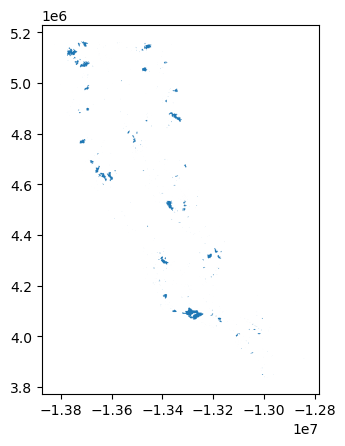

In [3]:
# Plot fire
fire.plot()

# Look at the first 5 rows of fire data
fire.head()

# Look at landsat data
landsat_new

### Analysis

**Creating True and False Color Images**
The creation of true and false color images utilizes specific bands from the Landsat data. These images are normalized to enhance visual contrast, aiding in the identification of different land features. Checks confirm the normalization process has occurred correctly.

**True Color Image**

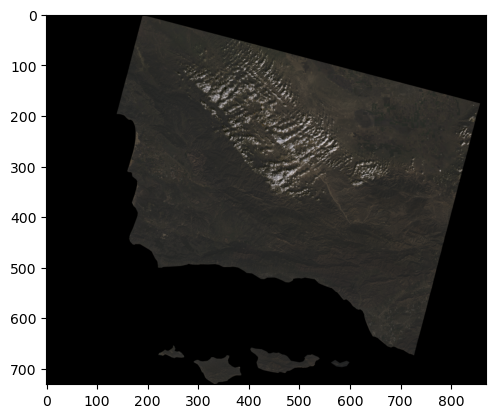

In [4]:
# Select R, G, B bands
red_band = landsat_new['red']
green_band = landsat_new['green']
blue_band = landsat_new['blue']

# Stack the bands along the 'color' dimension
rgb_image = xr.concat([red_band, green_band, blue_band], dim='color')
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Plot the RGB image 
plt.imshow(rgb_image.transpose('y', 'x', 'color')) 

# Visualize map
plt.show()

**False Color Image**

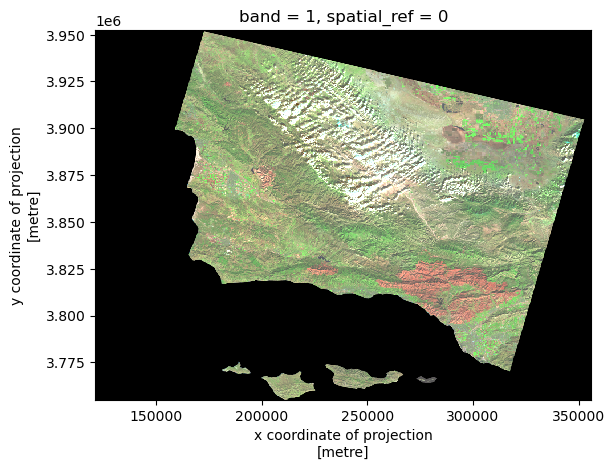

In [5]:
# Select spectral bands from the landsat data
swir22 = landsat_new['swir22']
nir    = landsat_new['nir08']
red    = landsat_new['red']

# Stack the bands along 'color' dimension
false_color_image = xr.concat([swir22, nir, red], dim='color')

# Normalize the false color image to increase contrast
false_image = (false_color_image - false_color_image.min()) / (false_color_image.max() - false_color_image.min())

# Plot the RGB image using imshow
landsat_new[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust= True)

### Final Output
The final output is a composite image that illustrates the affected area during the Thomas Fire. This output serves as a potent visual tool for understanding the spatial extent of wildfires and highlights the value of remote sensing in environmental monitoring and disaster assessment.

In [7]:
# Filter for Thomas fire
thomas_fire = fire[fire['FIRE_NAME']=="THOMAS"]

# Convert thomas_fire to GeoDataFrame to same crs as landsat
thomas_fire = thomas_fire.to_crs(landsat_new.rio.crs)

# Store false color map
false_color = landsat_new[['swir22', 'nir08', 'red']].to_array()

ProjError: x, y, z, and time must be same size

NameError: name 'false_color' is not defined

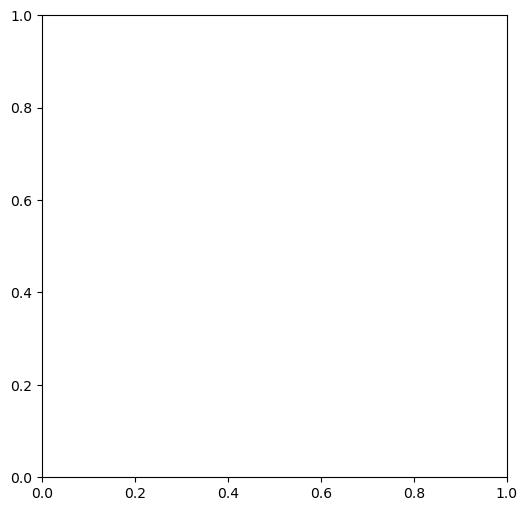

In [8]:
# Initiate figure
fig, ax = plt.subplots(figsize=(6,6))

# Plot outline of california and create key for legend
false_color.plot.imshow(ax=ax, robust=True)

# Plot lulc bounding box and create key for legend
thomas_fire.plot(ax=ax, color='red', alpha=0.5, edgecolor='black', linewidth=0.5)
thomas_patch = mpatches.Patch(color='red', label='Thomas Fire')

# Create legend
ax.legend(handles=[thomas_patch], frameon=True, loc='upper right', bbox_to_anchor=(1.4, 1))
ax.set_title('False Color Image of Santa Barbara with Thomas Fire Boundary')